# TODO
- NMS (Non Maximal Suppression)

# Library


In [2]:
# ! pip install wandb opencv-python-headless==4.2.0.32 albumentations==1.1.0 torch-summary timm==0.5.4 einops joblib icecream
! pip install wandb opencv-python-headless albumentations torch-summary timm==0.5.4 einops joblib icecream -U

  Using cached wandb-0.12.16-py2.py3-none-any.whl (1.8 MB)
  Using cached opencv_python_headless-4.5.5.64-cp37-abi3-macosx_11_0_arm64.whl (29.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 2.0 MB/s eta 0:00:0000:01
  Using cached torch_summary-1.4.5-py3-none-any.whl (16 kB)
  Using cached timm-0.5.4-py3-none-any.whl (431 kB)
  Using cached einops-0.4.1-py3-none-any.whl (28 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 kB 2.6 MB/s eta 0:00:00a 0:00:01
  Using cached icecream-2.1.2-py2.py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 2.6 MB/s eta 0:00:0000:01
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.3/962.3 kB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Using cached promise-2.3.ta

In [1]:
import os

# Pytorch
import torch
import torch.nn as nn
import torchvision.datasets as transforms
from torchvision.datasets import VOCDetection
from torch.utils.data import Dataset, DataLoader
import timm
from einops import rearrange, reduce, repeat
from torchsummary import summary



# Image Processing
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


# Debugging
from icecream import ic

# math, plotting
import matplotlib.pyplot as plt
from math import sqrt
import random

from tqdm import tqdm



/opt/homebrew/Caskroom/miniforge/base/envs/pytorch-nightly/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.has_mps

True

# CONFIG

In [3]:
CONFIG = dict(
    S=7,
    B=2,
    C=20,
    seed = 42,
    batch_size=1,
    height=384,   # y
    width=384,    # x
    lambda_coord=5,
    lambda_noobj=0.5,
    lr=1e-5,
    device=torch.device("mps"),
)


# SET SEED

In [4]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)


set_seed(CONFIG['seed'])


# Dataset and Dataloader


참고할 블로그

-   [PASCAL VOC DATASET 설명](https://ctkim.tistory.com/190)


In [5]:
# class myVOC(VOCDetection):
dataset = VOCDetection(root='./', year='2007',
                       image_set='train', download=True,)
dataloader = DataLoader(dataset=dataset, batch_size=1)

Using downloaded and verified file: ./VOCtrainval_06-Nov-2007.tar
Extracting ./VOCtrainval_06-Nov-2007.tar to ./


In [6]:
dataset.__getitem__(2)


(<PIL.Image.Image image mode=RGB size=334x500>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000023.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '220208496'},
   'owner': {'flickrid': 'thevelodrome.com', 'name': '?'},
   'size': {'width': '334', 'height': '500', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'bicycle',
     'pose': 'Unspecified',
     'truncated': '1',
     'difficult': '0',
     'bndbox': {'xmin': '9', 'ymin': '230', 'xmax': '245', 'ymax': '500'}},
    {'name': 'bicycle',
     'pose': 'Frontal',
     'truncated': '1',
     'difficult': '0',
     'bndbox': {'xmin': '230', 'ymin': '220', 'xmax': '334', 'ymax': '500'}},
    {'name': 'bicycle',
     'pose': 'Unspecified',
     'truncated': '1',
     'difficult': '1',
     'bndbox': {'xmin': '2', 'ymin': '178', 'xmax': '90', 'ymax': '500'}},
    {'name': 'person',
     'pose': 'Unspecified',
     'truncated': '1',
   

다음 과정을 통해 라벨에 번호를 부여합니다.

번호-라벨 쌍이 `labels_dict`에 저장됩니다


In [7]:
labels_list = ['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane',
               'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle',
               'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']

labels_name_dict = dict()
name_labels_dict = dict()
for i, label in enumerate(labels_list):
    labels_name_dict[i] = label
    name_labels_dict[label] = i


# Model


In [8]:
# """ 
# input : (3, 448, 448) - (C, H, W)
# output : S * S * (B * 5 + C)
# """

# # TODO : 적당한 backbone 모델로 변경하기
# class Yolo(nn.Module):
#     def __init__(self, S, B, C):
#         super().__init__()
#         # 모델 상수
#         self.S = S
#         self.B = B
#         self.C = C
        
#         # backbone
#         self.backbone = timm.create_model('tf_efficientnetv2_s_in21ft1k', pretrained=True)
#         # freeze backbone
#         # for param in self.backbone.parameters():
#         #     param.requires_grad = False
#         self.fc1 = nn.Linear(1280*12*12, 4096)
#         self.fc2 = nn.Linear(4096, self.S * self.S * (5 * self.B + self.C))
#         self.leakyRelu = nn.LeakyReLU(0.1)
#         self.flat = nn.Flatten()
#         self.sigmoid = nn.Sigmoid()



#     def forward(self, x):
#         x = self.backbone.conv_stem(x)
#         x = self.backbone.bn1(x)
#         x = self.backbone.blocks(x)
#         x = self.backbone.conv_head(x)
#         x = self.backbone.bn2(x)
#         x = self.backbone.act2(x)
#         ic(x.shape)
#         x = self.flat(x)
#         ic(x.shape)
#         x = self.fc1(x)
#         ic(x.shape)
#         x = self.leakyRelu(x)
#         ic(x.shape)
#         x = self.fc2(x)
#         ic(x.shape)
#         out= self.sigmoid(x)
#         out = rearrange(out, 'bs (S s X) -> bs S s X', S = self.S, s = self.S)

#         return out


In [9]:
""" 
input : (3, 448, 448) - (C, H, W)
output : S * S * (B * 5 + C)
"""

# TODO : 적당한 backbone 모델로 변경하기
class Yolo(nn.Module):
    def __init__(self, S, B, C):
        super().__init__()
        # 모델 상수
        self.S = S
        self.B = B
        self.C = C
        
        # backbone
        self.backbone = timm.create_model('tf_efficientnetv2_s_in21ft1k', pretrained=True)
        # freeze backbone
        # for param in self.backbone.parameters():
        #     param.requires_grad = False
        self.backbone.reset_classifier(self.S * self.S * (5 * self.B + self.C))
        self.sigmoid = nn.Sigmoid()




    def forward(self, x):
        out = self.backbone(x)
        out = self.sigmoid(out).clone()
        out = rearrange(out, 'bs (S s X) -> bs S s X', S = self.S, s = self.S)

        return out


In [10]:
yolo = Yolo(S=CONFIG['S'], B=CONFIG['B'], C=CONFIG['C'])
# pred : (S, S, (B *5 + C))
# pred = yolo(img)
# ic.enable()
# yolo(torch.randn(1,3,384,384)).shape
# summary(yolo, (3,384,384))
yolo = yolo.to(CONFIG['device'])


# Optimizer

In [11]:
optimizer = torch.optim.Adam(params=yolo.parameters(), lr=CONFIG['lr'])

# Functions

In [12]:
# 픽셀값으로 되어 있는 bbox 값을 (이미지 크기에 대한) 상대값으로 변경해줍니다
def bbox_transform(bbox: dict, img_height, img_width) -> dict:
    # ic(bbox['xmin'])
    bbox['xmin'] = int(bbox['xmin']) / img_width        # must be float
    bbox['xmax'] = int(bbox['xmax']) / img_width
    bbox['ymin'] = int(bbox['ymin']) / img_height
    bbox['ymax'] = int(bbox['ymax']) / img_height
    bbox['x'] = (bbox['xmin'] + bbox['xmax']) / 2
    bbox['y'] = (bbox['ymin'] + bbox['ymax']) / 2
    bbox['w'] = bbox['xmax'] - bbox['xmin']
    bbox['h'] = bbox['ymax'] - bbox['ymin']
    bbox['sqrt_w'] = sqrt(bbox['w'])
    bbox['sqrt_h'] = sqrt(bbox['h'])

    return bbox


In [13]:
# (x,y,w,h) tensor 둘을 받아서 IoU를 계산합니다
def IOU(bbox1: torch.Tensor, bbox2: torch.Tensor) -> torch.Tensor:
    assert len(bbox1) == 4, 'bbox1이 이상합니다'
    assert len(bbox2) == 4, 'bbox2가 이상합니다'

    max_x1 = bbox1[0] + (bbox1[2] / 2)
    min_x1 = bbox1[0] - (bbox1[2] / 2)
    max_y1 = bbox1[1] + (bbox1[3] / 2)
    min_y1 = bbox1[1] - (bbox1[3] / 2)

    max_x2 = bbox2[0] + (bbox2[2] / 2)
    min_x2 = bbox2[0] - (bbox2[2] / 2)
    max_y2 = bbox2[1] + (bbox2[3] / 2)
    min_y2 = bbox2[1] - (bbox2[3] / 2)

    # 직사각형 A, B의 넓이를 구한다.
    # get area of rectangle A and B
    rect1_area = (max_x1 - min_x1) * (max_y1 - min_y1)
    rect2_area = (max_x2 - min_x2) * (max_y2 - min_y2)

    # Intersection의 가로와 세로 길이를 구한다.
    # get length and width of intersection.
    intersection_x_length = min(max_x1, max_x2) - max(min_x1, min_x2)
    intersection_y_length = min(max_y1, max_y2) - max(min_y1, min_y2)
    
    
    # width와 length의 길이가 유효하다면 IoU를 구한다.
    # If the width and length are valid, get IoU.
    if (bool(intersection_x_length > 0) & bool(intersection_y_length > 0)):
        intersection_area = intersection_x_length * intersection_y_length
        union_area = rect1_area + rect2_area - intersection_area
        ret = intersection_area / union_area
    else :
        ret = 0
    return torch.Tensor([ret]).to(CONFIG['device'])

""" 
코드 출처
https://gaussian37.github.io/math-algorithm-iou/
"""




' \n코드 출처\nhttps://gaussian37.github.io/math-algorithm-iou/\n'

In [14]:
def sum_squared_loss(pred : torch.Tensor, target : torch.Tensor):
    epsilon = torch.Tensor([1e-5]).to(CONFIG['device'])
    if pred.dim() == 0:
        pred.unsqueeze_(0)
    if target.dim() == 0:
        target.unsqueeze_(0)
    assert len(pred) == len(target), '에러 : 두 텐서의 길이가 다릅니다'
    length = len(pred)
    sum = 0
    for i in range(length):
        mit = (pred[i] - target[i]).abs() + epsilon
        ic(pred[i])
        ic(target[i])
        ic(mit)
        assert mit > 0, '에러, 밑이 양수가 아닙니다'
        sum += pow(mit, 2)

    return sum.unsqueeze(0).to(CONFIG['device'])


# Loss Function

In [15]:
def loss_func(data, pred : torch.Tensor):

    pil_image = data[0]     # PIL 이미지
    numpy_image = np.array(pil_image)   # (H, W, C)

    # 이미지 height, width 저장
    img_height = numpy_image.shape[0]
    img_width = numpy_image.shape[1]

    # 각 이미지에 포함되어 있는 object 정보들에 대한 리스트
    original_obj_list = data[1]['annotation']['object']

    # 데이터 가공
    # bbox 값을 (이미지 크기에 대한) 상대값으로 설정
    # 딕셔너리의 리스트
    obj_list = list()
    for obj in original_obj_list:
        ratio_bbox = bbox_transform(
            bbox=obj['bndbox'], img_height=img_height, img_width=img_width)

        obj_info = dict()
        obj_info['name'] = obj['name']
        obj_info['bbox'] = ratio_bbox

        obj_list.append(obj_info)

    num_obj = len(obj_list)
    ic(num_obj)

    # ============ Loss 계산 ===========
    loss_list = list()

    # ============= Object가 존재하는 Cell의 Loss를 먼저 계산한다 =================
    for n in range(num_obj):

        """
        Example of obj_info:
        {'bbox': {'h': 0.56,
                'w': 0.31137724550898205,
                'x': 0.844311377245509,
                'xmax': 1.0,
                'xmin': 0.688622754491018,
                'y': 0.72,
                'ymax': 1.0,
                'ymin': 0.44},
        'name': 'bicycle'},
        """
        obj_info = obj_list[n]

        # (i,j) cell에 떨어진다고 할 때, (i,j)를 찾는다
        x = obj_info['bbox']['x']
        y = obj_info['bbox']['y']
        i = int(y * CONFIG['S'])
        j = int(x * CONFIG['S'])

        # 순회를 체크하기 위해 S X S Grid를 만든다.
        # 기본값은 0
        # object가 있는 cell은 1로 표시한다
        GRID = np.zeros((CONFIG['S'], CONFIG['S']))

        # 이미 해당 cell에 object가 있었다면 pass
        # YOLO는 한 cell에서 단 하나의 object만을 탐지하기 때문이다
        if (GRID[i][j] == 1):
            continue
        else:
            GRID[i][j] = 1

        # classification loss
        pred_probs = pred[i, j, 5*CONFIG['B']:]           # (C,) tensor
        label = name_labels_dict[obj_info['name']]      # Answer Label e.g.) 4
        label_probs = torch.zeros_like(pred_probs)
        label_probs[label] = 1.0
        
        loss_list.append(sum_squared_loss(pred_probs, label_probs))

        
        # Responsible한 bbox를 찾는다 : target bbox와의 IOU가 제일 큰 bbox
        max_IOU = torch.Tensor([-1]).to(CONFIG['device'])
        reponsible_bbox_num = -1
        # num_bbox 0 ~ B-1
        for num_bbox in range(CONFIG['B']):
            pred_coord = pred[i, j, 5 * (num_bbox): 5*(num_bbox) + 4]
            target_coord = torch.Tensor(
                [obj_info['bbox']['x'], obj_info['bbox']['y'], obj_info['bbox']['w'], obj_info['bbox']['h']]).to(CONFIG['device'])
            iou = IOU(target_coord, pred_coord).to(CONFIG['device'])
            if bool(iou > max_IOU):
                reponsible_bbox_num = num_bbox
                max_IOU = iou

        for num_bbox in range(CONFIG['B']):
            pred_coord = pred[i, j, 5 * (num_bbox): 5*(num_bbox) + 4]
            pred_confidence = pred[i, j, 5*(num_bbox) + 4]
            # pred_coord = pred_coord.to(CONFIG['device'])
            # pred_confidence = pred_confidence.to(CONFIG['device'])

            # responsible한 bbox의 경우
            if num_bbox == reponsible_bbox_num:
                pred_coord[2] = sqrt(pred_coord[2])     # w -> sqrt(w)
                pred_coord[3] = sqrt(pred_coord[3])     # h -> sqrt(h)

                target_coord = torch.Tensor(
                    [obj_info['bbox']['x'], obj_info['bbox']['y'], obj_info['bbox']['sqrt_w'], obj_info['bbox']['sqrt_h']])
                target_coord = target_coord.to(CONFIG['device'])

                # localization(coordinate) loss
                loss_list.append( CONFIG['lambda_coord'] * \
                    sum_squared_loss(pred_coord, target_coord))
                # confidence error loss
                loss_list.append(sum_squared_loss(pred_confidence, max_IOU))

            # reponsible하지 않은 bbox의 경우
            else:
                # If no object exists in cell, the  confidence scores should be zero
                loss_list.append(CONFIG['lambda_noobj'] * sum_squared_loss(pred_confidence, torch.Tensor([0]).to(CONFIG['device'])))

    # =========== Object가 존재하지 않는 Cell의 Loss ===========

    for i in range(CONFIG['S']):
        for j in range(CONFIG['S']):
            # 이미 loss를 계산했던 Cell인지 확인
            if (GRID[i][j] == 1):
                continue
            else:
                GRID[i][j] = 1

            for num_bbox in range(CONFIG['B']):
                pred_confidence = pred[i, j, 5*(num_bbox) + 4]
                loss_list.append(CONFIG['lambda_noobj'] * \
                    sum_squared_loss(pred_confidence, torch.Tensor([0]).to(CONFIG['device'])))

    loss = torch.sum(torch.cat(loss_list))
    return loss
                    


# Training Function

In [16]:
# Training
def train_one_epoch(epoch, device = 'cpu', batch_size = 1) :
    yolo.train()

    bar = tqdm(enumerate(dataset), total=len(dataset))

    loss_sum = 0
    epoch_loss = 0

    for step, data in bar:

        # 이미지 불러오기
        pil_image = data[0]     # PIL 이미지
        numpy_image = np.array(pil_image)   # (H, W, C)
        opencv_image = cv2.cvtColor(numpy_image, cv2.IMREAD_COLOR)  # (H, W, C)

        # 이미지 확인
        # TODO: 바운딩 박스까지 표시하는 이미지로 바꾸기
        plt.imshow(numpy_image)

        # numpy -> tensor
        transform = A.Compose([
            A.Resize(CONFIG['height'], CONFIG['width']),
            ToTensorV2(),
        ])
        transformed = transform(image=opencv_image)[
            'image']      # (C, H, W) Tensor
        transformed = rearrange(transformed, 'c h w -> 1 c h w').float()
        
        ic(transformed.shape)
        
        transformed = transformed.contiguous().to(CONFIG['device'])
        pred = yolo(transformed)        # (1, 7, 7, 30)
        pred = rearrange(pred, '1 a b c -> a b c')
        ic(pred)

        optimizer.zero_grad()

        loss = loss_func(data, pred)

        loss.backward()
        
        # for name, param in yolo.named_parameters():
        #     ic(name)
        #     ic(torch.sum(param.grad))

        optimizer.step()

        loss_sum += loss.item()

        epoch_loss = loss_sum / (step + 1)
            
        bar.set_postfix(Epoch = epoch, Loss = epoch_loss)
        break

    return epoch_loss
    

### Using Device mps ###


  0%|          | 0/2501 [00:00<?, ?it/s]ic| transformed.shape: torch.Size([1, 3, 384, 384])
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch-nightly/lib/python3.10/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1653116876854/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))
ic| pred: tensor([[[5.0367e-01, 3.7949e-01, 5.1368e-01,  ..., 4.8088e-01,
                    4.7995e-01, 5.6113e-01],
                   [3.9206e-01, 5.5269e-01, 5.8645e-01,  ..., 5.5619e-01,
                    4.0710e-01, 6.0074e-01],
                   [6.2628e-01, 5.5131e-01, 5.8436e-01,  ..., 5.5455e-01,
                    4.6464e-01, 4.8199e-01],
               

RuntimeError: Function 'AbsBackward0' returned nan values in its 0th output.

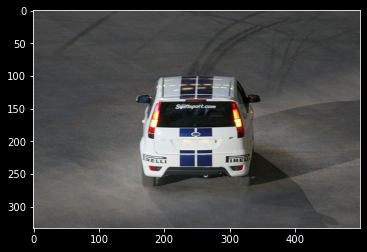

In [17]:
torch.autograd.set_detect_anomaly(True)
def run_training():
    Epoch = 1

    best_loss = np.inf
    for epoch in range(Epoch):
        epoch_loss = train_one_epoch(epoch=epoch, device=CONFIG['device'])

        if epoch_loss < best_loss :
            best_loss = epoch_loss
            file_prefix = 'YOLOV1'
            save_path = "{}epoch{:.0f}_Loss{:.4f}.bin".format(
                file_prefix, epoch, best_loss)
            torch.save(yolo.state_dict(), save_path)


ic.enable()
print('### Using Device {0} ###'.format(str(CONFIG['device'])))
run_training()